# Tutorial 04

## partial-sky ABS pipeline (with noise)

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

Measurement uncertainties are prepared as white noise.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.ps_estimator import pstimator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap30 = np.random.normal(0.,1.,size=vmap30.shape)*np.sqrt(vmap30)
nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=vmap353.shape)*np.sqrt(vmap353)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map30 = hp.smoothing(mapcmb+map30f,fwhm=fwhm[0],verbose=0) + nmap30
map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0) + nmap95
map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0) + nmap150
map353 = hp.smoothing(mapcmb+map353f,fwhm=fwhm[3],verbose=0) + nmap353

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=False)

RESAMP = 10  # size of resampling
BINNING = 10
NPIX = 12*NSIDE**2
APOSCALE = 6.

est = pstimator(nside=NSIDE, mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=BINNING)
cmb_dl = est.auto_teb(mapcmb)
cmb_dl = np.vstack([cmb_dl[0],cmb_dl[1],cmb_dl[4],cmb_dl[6]])
# calculate binned CMB band-power from input Cl
#cmb_dl = np.zeros((4,len(est.modes)))
#cmb_dl[0] = est.modes
#for i in range(len(est.modes)):
#    lrange = np.array(est._b.get_ell_list(i))
#    factor = 0.5*lrange*(lrange+1)/np.pi
#    w = np.array(est._b.get_weight_list(i))
#    for j in range(3):
#        cmb_dl[j+1,i] = np.sum(w*cmb_cl[j,lrange]*factor)

#### run ABS pipeline

- TT, EE and BB

CPU times: user 16min 58s, sys: 7.52 s, total: 17min 6s
Wall time: 2min 14s


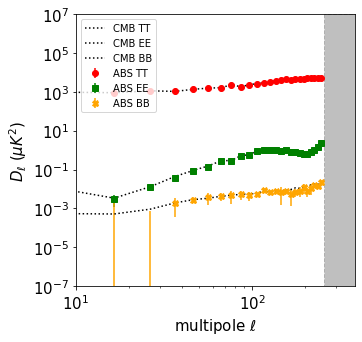

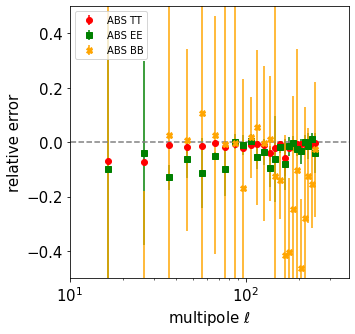

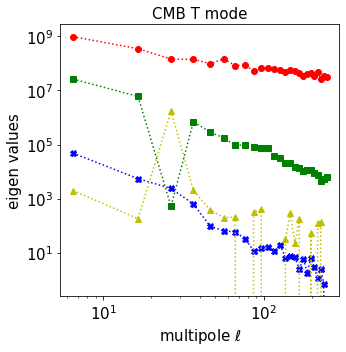

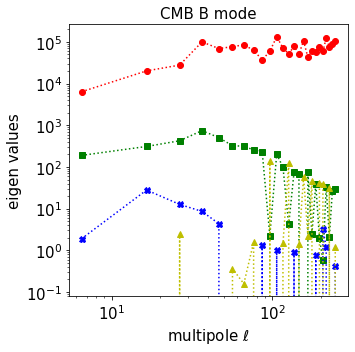

In [2]:
%%time

fullmap = dict()
fullmap[0] = map30[0].reshape(1,-1)
fullmap[1] = map95[0].reshape(1,-1)
fullmap[2] = map150[0].reshape(1,-1)
fullmap[3] = map353[0].reshape(1,-1)

fullvar = dict()
fullvar[0] = vmap30[0].reshape(1,-1)
fullvar[1] = vmap95[0].reshape(1,-1)
fullvar[2] = vmap150[0].reshape(1,-1)
fullvar[3] = vmap353[0].reshape(1,-1)

pipeline1 = af.abspipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,
                       fwhms=fwhm)
pipeline1.nsamp = RESAMP
rslt_t = pipeline1(aposcale=APOSCALE,psbin=BINNING,shift=10.,threshold=1.,verbose=True)

fullmap.clear()
fullmap[0] = map30[1:]
fullmap[1] = map95[1:]
fullmap[2] = map150[1:]
fullmap[3] = map353[1:]

fullvar.clear()
fullvar[0] = vmap30[1:]
fullvar[1] = vmap95[1:]
fullvar[2] = vmap150[1:]
fullvar[3] = vmap353[1:]

pipeline2 = af.abspipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,
                      fwhms=fwhm)
pipeline2.nsamp = RESAMP
rslt_eb = pipeline2(aposcale=APOSCALE,psbin=BINNING,shift=10.,threshold=1.,verbose=True)

fig,ax = plt.subplots(figsize=(5,5))

ax.plot(cmb_dl[0],cmb_dl[1],color='black',linestyle=':',label=r'CMB TT')
ax.plot(cmb_dl[0],cmb_dl[2],color='black',linestyle=':',label=r'CMB EE')
ax.plot(cmb_dl[0],cmb_dl[3],color='black',linestyle=':',label=r'CMB BB')

ax.errorbar(rslt_t[0],rslt_t[1],yerr=rslt_t[2],
            color='red',fmt='o',label=r'ABS TT')
ax.errorbar(rslt_eb[0],rslt_eb[1],yerr=rslt_eb[2],
            color='green',fmt='s',label=r'ABS EE')
ax.errorbar(rslt_eb[0],rslt_eb[3],yerr=rslt_eb[4],
            color='orange',fmt='X',label=r'ABS BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((10,3*NSIDE))

fig,ax = plt.subplots(figsize=(5,5))

ax.errorbar(rslt_t[0],(rslt_t[1]-cmb_dl[1])/cmb_dl[1],yerr=rslt_t[2]/cmb_dl[1],
            color='red',fmt='o',label=r'ABS TT')
ax.errorbar(rslt_eb[0],(rslt_eb[1]-cmb_dl[2])/cmb_dl[2],yerr=rslt_eb[2]/cmb_dl[2],
            color='green',fmt='s',label=r'ABS EE')
ax.errorbar(rslt_eb[0],(rslt_eb[3]-cmb_dl[3])/cmb_dl[3],yerr=rslt_eb[4]/cmb_dl[3],
            color='orange',fmt='X',label=r'ABS BB')
ax.plot((1,3*NSIDE),(0,0),color='grey',linestyle='--')

ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'relative error',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((-0.5,0.5))
ax.set_xlim((10,3*NSIDE))

fig,ax = plt.subplots(figsize=(5,5))
freq_list = [30,95,150,353]
eigens = np.empty((len(freq_list),len(rslt_t[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = rslt_t[-1][i][0]
ax.plot(rslt_t[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_t[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_t[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_t[0],eigens[3],linestyle=':',color='y',marker='^')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.set_title('CMB T mode', fontsize=15)
ax.tick_params(axis='both', labelsize=15)


fig,ax = plt.subplots(figsize=(5,5))
freq_list = [30,95,150,353]
eigens = np.empty((len(freq_list),len(rslt_eb[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = rslt_eb[-1][i][0] 
ax.plot(rslt_eb[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_eb[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_eb[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_eb[0],eigens[3],linestyle=':',color='y',marker='^')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.set_title('CMB B mode', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

- only BB

CPU times: user 28min 18s, sys: 598 ms, total: 28min 18s
Wall time: 3min 35s


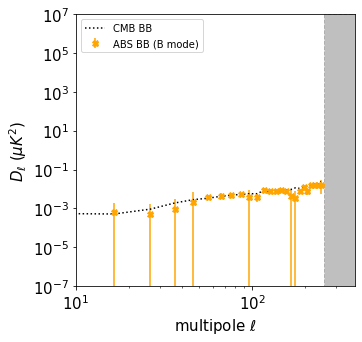

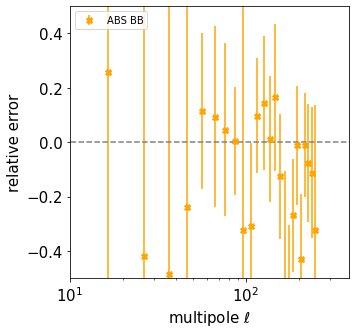

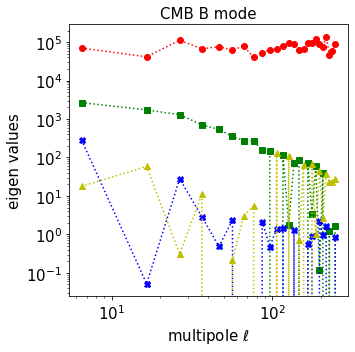

In [3]:
%%time

fullmap.clear()
fullmap[0] = map30
fullmap[1] = map95
fullmap[2] = map150
fullmap[3] = map353

fullvar.clear()
fullvar[0] = vmap30
fullvar[1] = vmap95
fullvar[2] = vmap150
fullvar[3] = vmap353

pipeline3 = af.abspipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,
                      fwhms=fwhm)
pipeline3.nsamp = RESAMP
rslt_b = pipeline3.run_bmode(aposcale=APOSCALE,psbin=BINNING,shift=10.,threshold=1.,verbose=True)

fig,ax = plt.subplots(figsize=(5,5))

ax.plot(cmb_dl[0],cmb_dl[3],color='black',linestyle=':',label=r'CMB BB')

ax.errorbar(rslt_b[0],rslt_b[1],yerr=rslt_b[2],
            color='orange',fmt='X',label=r'ABS BB (B mode)')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((10,3*NSIDE))


fig,ax = plt.subplots(figsize=(5,5))

ax.errorbar(rslt_b[0],(rslt_b[1]-cmb_dl[3])/cmb_dl[3],yerr=rslt_b[2]/cmb_dl[3],
            color='orange',fmt='X',label=r'ABS BB')
ax.plot((1,3*NSIDE),(0,0),color='grey',linestyle='--')

ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'relative error',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((-0.5,0.5))
ax.set_xlim((10,3*NSIDE))


fig,ax = plt.subplots(figsize=(5,5))
freq_list = [30,95,150,353]
eigens = np.empty((len(freq_list),len(rslt_b[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = rslt_b[-1][i][0] 
ax.plot(rslt_b[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_b[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_b[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_b[0],eigens[3],linestyle=':',color='y',marker='^')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.set_title('CMB B mode', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

end